In [1]:
# ------------------------------------------------- #
#  
#  ANALYSIS SCRIPT TO PROCESS DATA FROM QUANTUM COMPUTING CORRELATION FUNCTIONS TO EXTRACT TOPOLOGICAL PARAMETER
#  Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
#  arXiv:2210.03089
#
# Copyright 2023 Niklas Mueller, Joseph A. Carolan, Andrew Connelly, Zohreh Davoudi, Eugene F. Dumitrescu, Kübra Yeter-Aydeniz
# 
# Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the “Software”), 
# to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, 
# and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
# 
# The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.
# 
# THE SOFTWARE IS PROVIDED “AS IS”, WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, 
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER 
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS 
# IN THE SOFTWARE.
# 
# ------------------------------------------------- #

import sys
import os,csv
import numpy as np
np.set_printoptions(precision=4)
import pickle
import matplotlib.ticker as ticker
import math
import scipy
from scipy.stats import unitary_group
from qiskit import *
from qiskit.result import marginal_counts
from qiskit.providers.ibmq.job import job_monitor
from qiskit.tools.visualization import plot_histogram
from qiskit import transpile
import qiskit.quantum_info as qi
from qiskit.visualization import plot_histogram
%matplotlib inline

import INCLUDE.basic
import INCLUDE
from INCLUDE.basis_transformations import Bogoliubov_staggered_mom_to_particle_antiparticle
from INCLUDE.basis_transformations import SFFFT_mom_to_pos
from INCLUDE.basis_transformations import quench_gate
from INCLUDE.physics import dispersion
from INCLUDE.interactions import compute_couplings
from INCLUDE.interactions import interaction_part_controlled
from INCLUDE.interactions import interaction_part

# use this for AER simulator
from qiskit.providers.aer import QasmSimulator
# use this for IONQ simulator and devices
# from qiskit_ionq import IonQProvider
# use this for IONQ simulator and devices via Microsoft Azure
# from azure.quantum.qiskit import AzureQuantumProvider

In [2]:
# ------------------------------------------------- #
#  Parameters
# ------------------------------------------------- #
N = 4            # lattice sites
m = 0.9          # mass
n_shots = 1000   # shots
T = [0.0,0.4,0.8,2.4,2.8]           # list of all times data is produced for
RunName = "your_run_name" # optional give a custom run name
q_list = [-1,0]            # all modes in momentum space, must run from -N//4 to N//4-1 

# ------------------------------------------------- #
#  Circuit options
# ------------------------------------------------- #
RUN_RandI = 'Y'      # compute real and imaginary part in one circuit (Y/N)

# ------------------------------------------------- #
#  BACKEND
# ------------------------------------------------- #
run_backend = 'AER'       # choose backend

# ------------------------------------------------- #
#  PROVIDER
# ------------------------------------------------- #
my_provider='NONE'       # choose sprovider

In [3]:
# -------------------------------------------------- #
#  AER SIMULATOR 
# -------------------------------------------------- #
if run_backend=='AER':
    my_backend = BasicAer.get_backend('qasm_simulator')
    
# -------------------------------------------------- #
#  OTHER PROVIDER
# -------------------------------------------------- #
# elif run_backend=='XXXX':
#     if my_provider == 'YYYY':
       
            
print("# analyzing data from",my_backend)

# analyzing data from qasm_simulator


In [4]:
# ------------------------------------------------------------------------------ #
#  DATA INPUT
# ------------------------------------------------------------------------------ #
folder_load = np.zeros((len(q_list),len(T)),object)

for i_q in range(len(q_list)):
    for i_t in range(len(T)):
        folder_load[i_q][i_t]='output_folder_topo_q-'+str(q_list[i_q])+'_T-'+str(T[i_t])
    
        print("# loading from folder",folder_load[i_q][i_t])

# loading from folder output_folder_topo_q--1_T-0.0
# loading from folder output_folder_topo_q--1_T-0.4
# loading from folder output_folder_topo_q--1_T-0.8
# loading from folder output_folder_topo_q--1_T-2.4
# loading from folder output_folder_topo_q--1_T-2.8
# loading from folder output_folder_topo_q-0_T-0.0
# loading from folder output_folder_topo_q-0_T-0.4
# loading from folder output_folder_topo_q-0_T-0.8
# loading from folder output_folder_topo_q-0_T-2.4
# loading from folder output_folder_topo_q-0_T-2.8


In [5]:
# ------------------------------------------------------------------------------ #
#  LOAD DATA
# ------------------------------------------------------------------------------ #

# if running R and I parts separately
if RUN_RandI=='N':

    N_jobs = 16
    rec_transpiled = np.zeros((len(q_list),len(T),N_jobs),object)
    rec_circuit = np.zeros((len(q_list),len(T),N_jobs),object)
    rec_job_list = np.zeros((len(q_list),len(T)),object)
    s_list_R = np.zeros(len(T),object)
    s_list_I = np.zeros(len(T),object)
    pref_list_R = np.zeros(len(T),object)
    pref_list_I = np.zeros(len(T),object)

    # loop over momenta
    for i_q in range(len(q_list)):
        # loop over times
        for i_t in range(len(T)):

            with open(folder_load[i_q][i_t]+'/job_list') as file:
                lines = file.readlines()
                lines = [line.rstrip() for line in lines]

            rec_job_list[i_q][i_t]=lines

            if i_q==0:
                with open(folder_load[i_q][i_t]+'/s_list_R') as file:
                    lines = file.readlines()
                    lines = [line.rstrip() for line in lines]

                s_list_R[i_t]=lines

                with open(folder_load[i_q][i_t]+'/s_list_I') as file:
                    lines = file.readlines()
                    lines = [line.rstrip() for line in lines]

                s_list_I[i_t]=lines
                temp_R = np.loadtxt(folder_load[i_q][i_t]+'/pref_list_R')
                temp_I = np.loadtxt(folder_load[i_q][i_t]+'/pref_list_I')
                pref_list_R[i_t] = temp_R[:,1]+temp_R[:,2]*1.j
                pref_list_I[i_t] = temp_I[:,1]+temp_I[:,2]*1.j

            # load circuits for real part
            for i_s in range(N_jobs//2):

                filename_circuit=folder_load[i_q][i_t]+'/circuit_R-'+str(i_s)+'_'+s_list_R[i_t][i_s]+'_id-'+str(rec_job_list[i_q][i_t][i_s])
                file_circuit = open(filename_circuit, 'rb') 
                rec_circuit[i_q][i_t][i_s] =  pickle.load(file_circuit)
                file_circuit.close() 

#                 if run_backend=='XXXX':
#                     filename_transp_circuit=folder_load[i_q][i_t]+'/transp_circuit_R_+'+str(i_s)+'_'+s_list_R[i_t][i_s]+'_id-'+str(rec_job_list[i_q][i_t][i_s])
#                     file_transp_circuit = open(filename_transp_circuit, 'rb') 
#                     rec_transpiled[i_q][i_t][i_s] =  pickle.load(file_transp_circuit)
#                     file_transp_circuit.close()
            # END load circuits for real part


            # Load imag part circuits 
            for i_s in range(N_jobs//2,N_jobs):

                filename_circuit=folder_load[i_q][i_t]+'/circuit_I-'+str(i_s-N_jobs//2)+'_'+s_list_I[i_t][i_s-N_jobs//2]+'_id-'+str(rec_job_list[i_q][i_t][i_s])
                file_circuit = open(filename_circuit, 'rb') 
                rec_circuit[i_q][i_t][i_s] =  pickle.load(file_circuit)
                file_circuit.close()

#                 if run_backend=='XXXX':
#                     filename_transp_circuit=folder_load[i_q][i_t]+'/transp_circuit_I_+'+str(i_s-N_jobs//2)+'_'+s_list_I[i_t][i_s-N_jobs//2]+'_id-'+str(rec_job_list[i_q][i_t][i_s])
#                     file_transp_circuit = open(filename_transp_circuit, 'rb') 
#                     rec_transpiled[i_q][i_t][i_s] =  pickle.load(file_transp_circuit)
#                     file_transp_circuit.close()
            # END load imag part circuits
            
# if running R and I parts in one circuit
elif RUN_RandI=='Y':
    N_jobs = 8
    rec_transpiled = np.zeros((len(q_list),len(T),N_jobs),object)
    rec_circuit = np.zeros((len(q_list),len(T),N_jobs),object)
    rec_job_list = np.zeros((len(q_list),len(T)),object)
    s_list = np.zeros(len(T),object)
    pref_list = np.zeros(len(T),object)
    
    # loop over momenta
    for i_q in range(len(q_list)):
        # loop over times
        for i_t in range(len(T)):

            with open(folder_load[i_q][i_t]+'/job_list') as file:
                lines = file.readlines()
                lines = [line.rstrip() for line in lines]

            rec_job_list[i_q][i_t]=lines

            if i_q==0:

                with open(folder_load[i_q][i_t]+'/s_list') as file:
                    lines = file.readlines()
                    lines = [line.rstrip() for line in lines]

                s_list[i_t]=lines

                temp = np.loadtxt(folder_load[i_q][i_t]+'/pref_list')
                pref_list[i_t] = temp[:,1]+temp[:,2]*1.j
                
            # load circuits 
            for i_s in range(N_jobs):
           
                filename_circuit=folder_load[i_q][i_t]+'/circuit-'+str(i_s)+'_'+s_list[i_t][i_s]+'_id-'+str(rec_job_list[i_q][i_t][i_s])
                file_circuit = open(filename_circuit, 'rb') 
                rec_circuit[i_q][i_t][i_s] =  pickle.load(file_circuit)
                file_circuit.close()
                
#                 if run_backend=='XXXX': 
#                     filename_transp_circuit=folder_load[i_q][i_t]+'/transp_circuit_'+str(i_s)+'_'+s_list[i_t][i_s]+'_id-'+str(rec_job_list[i_q][i_t][i_s])
#                     file_transp_circuit = open(filename_transp_circuit, 'rb') 
#                     rec_transpiled[i_q][i_t][i_s] =  pickle.load(file_transp_circuit)
#                     file_transp_circuit.close()
            # END load circuits 
                 

FileNotFoundError: [Errno 2] No such file or directory: 'output_folder_topo_q--1_T-0.0/job_list'

In [6]:
# ------------------------------------------------------------------------------ #
#  LOAD DATA
# ------------------------------------------------------------------------------ #
# if run_backend=='XXXX':
    
#     if RUN_RandI=='N':
#         N_jobs=16
#     elif RUN_RandI=='Y':
#         N_jobs=8
    
#     retrieved = np.zeros((len(q_list),len(T),N_jobs),object)
#     all_counts = np.zeros((len(q_list),len(T),N_jobs),object)

#     for i_q in range(len(q_list)):
#         for i_t in range(len(T)):
#             for i_s in range(N_jobs):
#                 retrieved[i_q][i_t][i_s] = my_backend.retrieve_job(rec_job_list[i_q][i_t][i_s])

                                        
if run_backend=='AER':
    
    all_counts = np.zeros((len(q_list),len(T),N_jobs),object)
    
    for i_q in range(len(q_list)):
        for i_t in range(len(T)):
            
            if RUN_RandI=='N': 
            
                for i_s in range(N_jobs//2):
                    filename_result=folder_load[i_q][i_t]+'/resultR-'+str(i_s)+'_'+s_list[i_t][i_s]+'_id-'+rec_job_list[i_q][i_t][i_s]
                    file_result = open(filename_result, 'rb') 
                    temp=pickle.load(file_result)
                    file_result.close()
                    
                    all_counts[i_q][i_t][i_s] = temp.get_counts()
                    
                for i_s in range(N_jobs//2,N_jobs):
                    filename_result=folder_load[i_q][i_t]+'/resultI-'+str(i_s)+'_'+s_list[i_t][i_s]+'_id-'+rec_job_list[i_q][i_t][i_s]
                    file_result = open(filename_result, 'rb') 
                    temp=pickle.load(file_result)
                    file_result.close()
                    
                    all_counts[i_q][i_t][i_s] = temp.get_counts()
                    
            elif RUN_RandI=='Y':
                for i_s in range(N_jobs):
                    
                    filename_result=folder_load[i_q][i_t]+'/result-'+str(i_s)+'_'+s_list[i_t][i_s]+'_id-'+rec_job_list[i_q][i_t][i_s]
                    file_result = open(filename_result, 'rb') 
                    temp=pickle.load(file_result)
                    file_result.close()
                    
                    all_counts[i_q][i_t][i_s] = temp.get_counts()
                
                
                
    

In [6]:
# --------------------------------------------------------- #
# SYMMETRY BASED ERROR MITIGATION
# --------------------------------------------------------- #
def to_binary(s,N):
    return format(s, '0'+str(N)+'b')

def allowed_results(my_NN):

    sum_allowed_half=0
    sum_allowed_pairs=0
    allowed_half=[]
    allowed_pairs=[]
    
    for s in range(2**my_NN):
        sum_occ = 0
        my_occ = np.zeros(my_NN,int)

        for i in range(my_NN):
            i_occ = (s>>i)&1
            sum_occ += i_occ
            my_occ[i] = i_occ

        if sum_occ == my_NN//2:
            allowed_half.append(to_binary(s,my_NN))
            sum_allowed_half +=1 

        temp=np.zeros(my_NN//2,int)
        for j in range(my_NN//2):
            if my_occ[2*j] == my_occ[2*j+1]:
                temp[j]=True
            else:
                temp[j]=False

        allowed=True
        for j in range(len(temp)):
            if temp[j]==False:
                allowed=False
                
        if allowed==True:
            allowed_pairs.append(to_binary(s,my_NN))
            sum_allowed_pairs+=1
             
    return allowed_pairs,allowed_half,sum_allowed_pairs,sum_allowed_half

allowed_pairs,allowed_half,sum_allowed_pairs,sum_allowed_half=allowed_results(2)
        
print("# physical states half filling",sum_allowed_half,allowed_half) 
print("# physical states pairs",sum_allowed_pairs,allowed_pairs) 

# physical states half filling 2 ['01', '10']
# physical states pairs 2 ['00', '11']


In [7]:
# ------------------------------------------------------------------------ #
# Compute correlation functions
# ------------------------------------------------------------------------ #
def detect_symmetry_errors(my_counts):
    
    measurements = np.zeros(2**(2+1),float)

    my_prob_ones,my_prob_zeros = 0.0,0.0
    my_prob_ones_corrected,my_prob_zeros_corrected = 0.0,0.0
    
    my_physical_events,my_total_events = 0, 0
    
    physical_keys=[]

    for key in my_counts:
        
        is_physical=True
        
        # measure ancilla
        # NOTE string is read from right to left
        if key[2]=='0':
            my_prob_zeros+=my_counts[key] 
        elif key[2]=='1':
             my_prob_ones+=my_counts[key]
        
        my_total_events+=my_counts[key] 
                
        # measure the rest
        system_qubits = key[:2]
        
        if system_qubits in allowed_pairs:
            is_physical=True
        else:
            is_physical=False
        
        # only include corrected results
        if is_physical==True:
            my_physical_events += my_counts[key] 
            physical_keys.append(key)
            if key[2]=='0':
                my_prob_zeros_corrected+=my_counts[key] 
            elif key[2]=='1':
                my_prob_ones_corrected+=my_counts[key]
                
    corrected_counts = dict.fromkeys(physical_keys)
    
    for key in my_counts:
        
        system_qubits = key[:2]
        if system_qubits in allowed_pairs:
            is_physical=True
        else:
            is_physical=False
            
        if is_physical==True:
            corrected_counts[key] = my_counts[key] 
    
    my_prob_zeros_corrected = my_prob_zeros_corrected / my_physical_events
    my_prob_ones_corrected = my_prob_ones_corrected / my_physical_events
    
    my_prob_zeros = my_prob_zeros / my_total_events
    my_prob_ones = my_prob_ones / my_total_events
    
    return my_prob_ones_corrected,my_prob_zeros_corrected,my_prob_ones,my_prob_zeros,my_physical_events,my_total_events,corrected_counts
 
def detect_symmetry_errors_RandI(my_counts,component):
    
    if component == 'I':
        ancilla=2
    elif component =='R':
        ancilla=5
        
    measurements = np.zeros(2**(2+1),float)

    my_prob_ones,my_prob_zeros = 0.0,0.0
    my_prob_ones_corrected,my_prob_zeros_corrected = 0.0,0.0
    
    my_physical_events,my_total_events = 0, 0
    
    physical_keys=[]

    for key in my_counts:
        
        is_physical=True

        # measure ancilla
        # NOTE string is read from right to left
        if key[ancilla]=='0':
            my_prob_zeros+=my_counts[key] 
        elif key[ancilla]=='1':
             my_prob_ones+=my_counts[key]
        
        my_total_events+=my_counts[key] 
                
        # measure the rest
        if component == 'I':
            system_qubits = key[:2]
        elif component =='R':
            system_qubits = key[3:5]

        if system_qubits in allowed_pairs:
            is_physical=True
        else:
            is_physical=False
        
        # only include corrected results
        if is_physical==True:
            my_physical_events += my_counts[key] 
            physical_keys.append(key)
            if key[ancilla]=='0':
                my_prob_zeros_corrected+=my_counts[key] 
            elif key[ancilla]=='1':
                my_prob_ones_corrected+=my_counts[key]
                
    corrected_counts = dict.fromkeys(physical_keys)
    
    for key in my_counts:
        
        if component == 'I':
            system_qubits = key[:2]
        elif component =='R':
            system_qubits = key[3:5]
            
        if system_qubits in allowed_pairs:
            is_physical=True
        else:
            is_physical=False
            
        if is_physical==True:
            corrected_counts[key] = my_counts[key] 
    
    my_prob_zeros_corrected = my_prob_zeros_corrected / my_physical_events
    my_prob_ones_corrected = my_prob_ones_corrected / my_physical_events
    
    my_prob_zeros = my_prob_zeros / my_total_events
    my_prob_ones = my_prob_ones / my_total_events
 
    return my_prob_ones_corrected,my_prob_zeros_corrected,my_prob_ones,my_prob_zeros,my_physical_events,my_total_events,corrected_counts
 

In [9]:
# ------------------------------------------------------------------------ #
# Compute correlation functions
# ------------------------------------------------------------------------ #

def compute_correlator(my_data):
    
    overlap = np.zeros((len(q_list),len(T)),complex)
    overlap_raw = np.zeros((len(q_list),len(T)),complex)
    
    Nphys_R = np.zeros((len(q_list),len(T),8),int)
    Nphys_I = np.zeros((len(q_list),len(T),8),int)
    Ntotal_R = np.zeros((len(q_list),len(T),8),int)
    Ntotal_I = np.zeros((len(q_list),len(T),8),int)
    
    
    if RUN_RandI == 'N':
        LoopLength = len(s_list_R[0])
    elif RUN_RandI == 'Y':
        LoopLength = len(s_list[0])
        
    print("# loop length",LoopLength)
        
    for i_q in range(len(q_list)):
        for i_t in range(len(T)):
            for i_s in range(LoopLength):

                if RUN_RandI == 'N':
                    p_ones_c_R,p_zeros_c_R, p_ones_R,p_zeros_R, Nphys_R[i_q][i_t][i_s], Ntotal_R[i_q][i_t][i_s], corr_res_R = detect_symmetry_errors(my_data[i_q][i_t][i_s])
                    p_ones_c_I,p_zeros_c_I, p_ones_I,p_zeros_I, Nphys_I[i_q][i_t][i_s], Ntotal_I[i_q][i_t][i_s], corr_res_I = detect_symmetry_errors(my_data[i_q][i_t][i_s+LoopLength])
                elif RUN_RandI == 'Y':
                    p_ones_c_R,p_zeros_c_R, p_ones_R,p_zeros_R, Nphys_R[i_q][i_t][i_s], Ntotal_R[i_q][i_t][i_s], corr_res_R = detect_symmetry_errors_RandI(my_data[i_q][i_t][i_s],"R")
                    p_ones_c_I,p_zeros_c_I, p_ones_I,p_zeros_I, Nphys_I[i_q][i_t][i_s], Ntotal_I[i_q][i_t][i_s], corr_res_I = detect_symmetry_errors_RandI(my_data[i_q][i_t][i_s],"I")
                    
                    
                resR = p_zeros_c_R - p_ones_c_R
                resI = p_zeros_c_I - p_ones_c_I

                res = resR + 1.j*resI

                if RUN_RandI == 'N':
                    overlap[i_q][i_t] += 0.25 * pref_list_R[i_t][i_s] * res
                elif RUN_RandI == 'Y':
                    overlap[i_q][i_t] += 0.25 * pref_list[i_t][i_s] * res

                resR_raw = p_zeros_R - p_ones_R
                resI_raw = p_zeros_I - p_ones_I

                res_raw = resR_raw + 1.j*resI_raw

                if RUN_RandI == 'N':
                    overlap_raw[i_q][i_t] += 0.25 * pref_list_R[i_t][i_s] * res_raw
                elif RUN_RandI == 'Y':
                    overlap_raw[i_q][i_t] += 0.25 * pref_list[i_t][i_s] * res_raw
                
    return overlap,overlap_raw, Nphys_R, Nphys_I, Ntotal_R, Ntotal_I

In [8]:
# ------------------------------------------------------------------------ #
# Compute correlation functions
# ------------------------------------------------------------------------ #

# momentum space correlator
Lqt,Lqt_raw,Nphys_R,Nphys_I,Ntotal_R,Ntotal_I=compute_correlator(all_counts)

# compute ratefunction
Lt,Lt_raw = np.zeros(len(T),complex),np.zeros(len(T),complex)
ratef,ratef_raw=np.zeros(len(T),float),np.zeros(len(T),float)

for i_t in range(len(T)):
    Lt[i_t]=1.0
    Lt_raw[i_t]=1.0
    for q in range(N//2):
        Lt[i_t] *= Lqt[q,i_t] 
        Lt_raw[i_t] *= Lqt_raw[q,i_t] 
        
    ratef[i_t] = -np.log(np.abs(Lt[i_t]))/N
    ratef_raw[i_t] = -np.log(np.abs(Lt_raw[i_t]))/N
    

NameError: name 'compute_correlator' is not defined

NameError: name 'Lqt_raw' is not defined

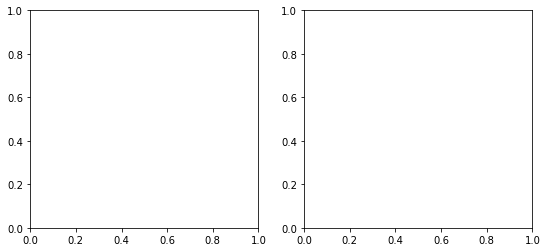

In [9]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(9,4))
ax1,ax2 = plt.subplot(121),plt.subplot(122)


ax1.plot(m*np.array(T), np.real(Lqt_raw[0]),linestyle='None',marker='s',color='b',label=r'$q=-1$')
ax1.plot(m*np.array(T), np.real(Lqt_raw[1]),linestyle='None',marker='s',color='r',label=r'$q=0$')

ax2.plot(m*np.array(T), np.imag(Lqt_raw[0]),linestyle='None',marker='s',color='b',label=r'$q=-1$')
ax2.plot(m*np.array(T), np.imag(Lqt_raw[1]),linestyle='None',marker='s',color='r',label=r'$q=0$')


In [10]:
# topological order parameter
def TO_parameter(my_Lqt,my_times):
    
    Nt, Nk = my_Lqt.shape

    dphi_kt_k = np.zeros((Nk,Nt-1))
    dphi_kt_t = np.zeros((Nk,Nt-1))
    Fkt = np.zeros((Nk,Nt-2))
    output_times = np.zeros(Nt-2)

    for k in range(Nk):
        for t in range(Nt-1):
            dphi_kt_k[k,t] = np.angle(my_Lqt[t,(k+1)%Nk]/my_Lqt[t,k])
            dphi_kt_t[k,t] = np.angle(my_Lqt[t+1,k]/my_Lqt[t,k])

    for k in range(Nk):
        for t in range(Nt-2):
            Fkt[k,t] = (dphi_kt_k[k,t] + dphi_kt_t[(k+1)%Nk,t]) - (dphi_kt_k[k,t+1] + dphi_kt_t[k,t])
            output_times[t] = 0.5*(times[t]+times[t+1])

    Fkt_ksum1 = np.zeros(Nt-2)
    Fkt_ksum2 = np.zeros(Nt-2)
    for k in range(Nk//2):
        Fkt_ksum1 += Fkt[(k),:]/2/np.pi
        Fkt_ksum2 += Fkt[(k+Nk//2),:]/2/np.pi


    n1 = []
    n2 = []
    for t in range(Nt-2):
        ntau1 = 0
        ntau2 = 0
        for tau in range(0,t):
            ntau1 += Fkt_ksum1[tau]
            ntau2 += Fkt_ksum2[tau]
        n1.append(ntau1)
        n2.append(ntau2)
    n1 = np.array(n1)
    n2 = np.array(n2)
    
    return n1,n2,output_times

In [11]:
# ------------------------------------------------------------------ #
# compute topological order parameter
# ------------------------------------------------------------------ #

# interpolate data so that integration routine will not fail
from scipy.interpolate import interp1d

dt = 0.1
times = np.arange(0.0,T[-1],dt)

Lqt_analysis = np.zeros((len(times),len(q_list)),complex)
Lqt_analysis_raw = np.zeros((len(times),len(q_list)),complex)

for i_q in range(len(q_list)):
    
    re = np.real(Lqt[i_q])
    im = np.imag(Lqt[i_q])
    fn_R = interp1d(T, re)
    fn_I = interp1d(T, im)
    
    re_raw = np.real(Lqt_raw[i_q])
    im_raw = np.imag(Lqt_raw[i_q])
    fn_R_raw = interp1d(T, re_raw)
    fn_I_raw = interp1d(T, im_raw)
    
    for i_t in range(len(times)):
        Lqt_analysis[i_t][i_q] = fn_R(times[i_t]) + 1.j*fn_I(times[i_t])
        Lqt_analysis_raw[i_t][i_q] = fn_R_raw(times[i_t]) + 1.j*fn_I_raw(times[i_t])
        
n1,n2,out_times=TO_parameter(Lqt_analysis,times)
n1_raw,n2_raw,out_times=TO_parameter(Lqt_analysis_raw,times)

NameError: name 'Lqt' is not defined

NameError: name 'out_times' is not defined

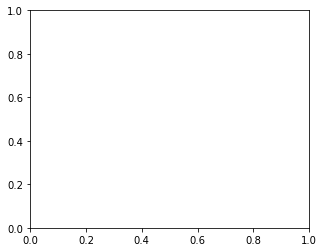

In [12]:
f = plt.figure(figsize=(5,4))
ax1 = plt.subplot(111)

ax1.plot(m*out_times,n2_raw-n1_raw,linestyle='None',linewidth=1,marker='s',color='b',label='500 shots, ideal raw')
ax1.plot(m*out_times,n2-n1,linestyle='None',linewidth=1,marker='^',mfc='None',color='lightblue',label='500 shots, ideal')

ax1.set_ylim([-0.1,2.6])
ax1.set_xlim([-0.1,2.])

